# Previsão de Votação de Deputados

### Sobre a tarefa

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).
2. Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. Isso implica, dentre outras coisas:
    - Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.   
    - Construir modelos de regressão com (ridge e lasso) e sem regularização.    
    - Considerar também modelos de regressão não paramétrica como K-NN.    
    - Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).    
    - Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.    
    - Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
    - Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.    
4. Responder:
    - Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.
    
A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

### Sobre os dados

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

|  Variável  | Tipo | Descrição |
|:------------|:------:|:-----------|
|"sequencial_candidato" | (character) | id do candidato|
|"nome"| (character) | |
|"uf" | (character) | |
|"partido" | (character)| |
|"quantidade_doacoes"| (integer)| |
|"quantidade_doadores"| (integer) | número de doadores diferentes|
|"total_receita" | (double) | soma em R\$ das doações |
|"media_receita" | (double) | média das doações |
|"recursos_de_outros_candidatos/comites" | (double) | quantia em R\$ das doações provenientes de outros candidatos ou comite partidário |
|"recursos_de_pessoas_fisicas" | (double) | quantia em R\$ das doações provenientes de outros CPFs |
|"recursos_de_pessoas_juridicas" | (double) | quantia em R\$ das doações provenientes de outros CNPJ |
|"recursos_proprios" | (double) | quantia em R\$ das doações provenientes do próprio candidato |
|"recursos_de_partido_politico" | (double) | quantia em R\$ das doações provenientes do partido político do candidato |
|**"votos"** | (integer) | **variável alvo**. Se refere ao número de votos na campanha de 2006 e 2010 |
|"quantidade_despesas" | (integer) | |
|"quantidade_fornecedores" | (integer) | número de fornecedores/despesas diferentes |
|"total_despesa" | (double) | soma em R$ das despesas de campanha |
|"media_despesa" | (double) | média das despesas de campanha |
|"cargo" |(character) | |
|"Sexo": | (character) | |
|"grau": | (character) | grau de instrução do candidato |
|"estado_civil" | (character) |
|"ocupacao" | (character) | ocupação do candidato |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import metrics

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Carregando o dataset eleições
eleicoes2006a2010 = pd.read_csv('eleicoes_2006_a_2010.csv')

### Conferindo os dados

In [3]:
eleicoes2006a2010.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


In [4]:
eleicoes2006a2010.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 23 columns):
ano                                      7330 non-null int64
sequencial_candidato                     7330 non-null int64
nome                                     7330 non-null object
uf                                       7330 non-null object
partido                                  7330 non-null object
quantidade_doacoes                       7330 non-null int64
quantidade_doadores                      7330 non-null int64
total_receita                            7169 non-null float64
media_receita                            7169 non-null float64
recursos_de_outros_candidatos/comites    4940 non-null float64
recursos_de_pessoas_fisicas              4647 non-null float64
recursos_de_pessoas_juridicas            3354 non-null float64
recursos_proprios                        4942 non-null float64
quantidade_despesas                      7330 non-null int64
quantidade_fornecedores 

In [5]:
eleicoes2006a2010.describe()

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7.330000e+03,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,9.179127e+10,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,9.924629e+10,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000100e+04,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,1.056500e+04,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,5.000000e+10,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,1.900000e+11,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,2.700000e+11,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


In [6]:
# Visualizando as colunas do dataset
eleicoes2006a2010.columns

Index(['ano', 'sequencial_candidato', 'nome', 'uf', 'partido',
       'quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos'],
      dtype='object')

In [7]:
eleicoes2006a2010.shape

(7330, 23)

In [8]:
eleicoes2006a2010.isnull().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    2390
recursos_de_pessoas_fisicas              2683
recursos_de_pessoas_juridicas            3976
recursos_proprios                        2388
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

Verificamos que as colunas (total_receita, media_receita, recursos_de_outros_candidatos/comites, recursos_de_pessoas_fisicas, recursos_proprios) tem valores faltantes.

## Pré-processamento dos dados 

#### Separando os datasets de treino e teste

In [9]:
# Separando os datasets para treino e teste
# Treino
eleicoes2006 = eleicoes2006a2010[eleicoes2006a2010['ano'] == 2006]
# Selecionando os atributos a serem utilizados no treino
train = eleicoes2006.loc[:,['uf', 'partido','quantidade_doacoes', 'quantidade_doadores', 
       'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]
# Teste
eleicoes2010 = eleicoes2006a2010[eleicoes2006a2010['ano'] == 2010]
# Selecionando os atributos a serem utilizados no teste
test = eleicoes2010.loc[:,['uf', 'partido','quantidade_doacoes', 'quantidade_doadores', 
       'total_receita', 'media_receita', 'recursos_de_outros_candidatos/comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'cargo', 'sexo', 'grau',
       'estado_civil', 'ocupacao', 'votos']]


### Preparando os dados para utilizar no modelo

In [10]:
# Concatenando os dataframes de treino e teste
df = pd.concat((train,test))
# Separando os atributos preditores do atributo alvo
X = df.loc[:,'uf':'estado_civil']
y = df['votos']

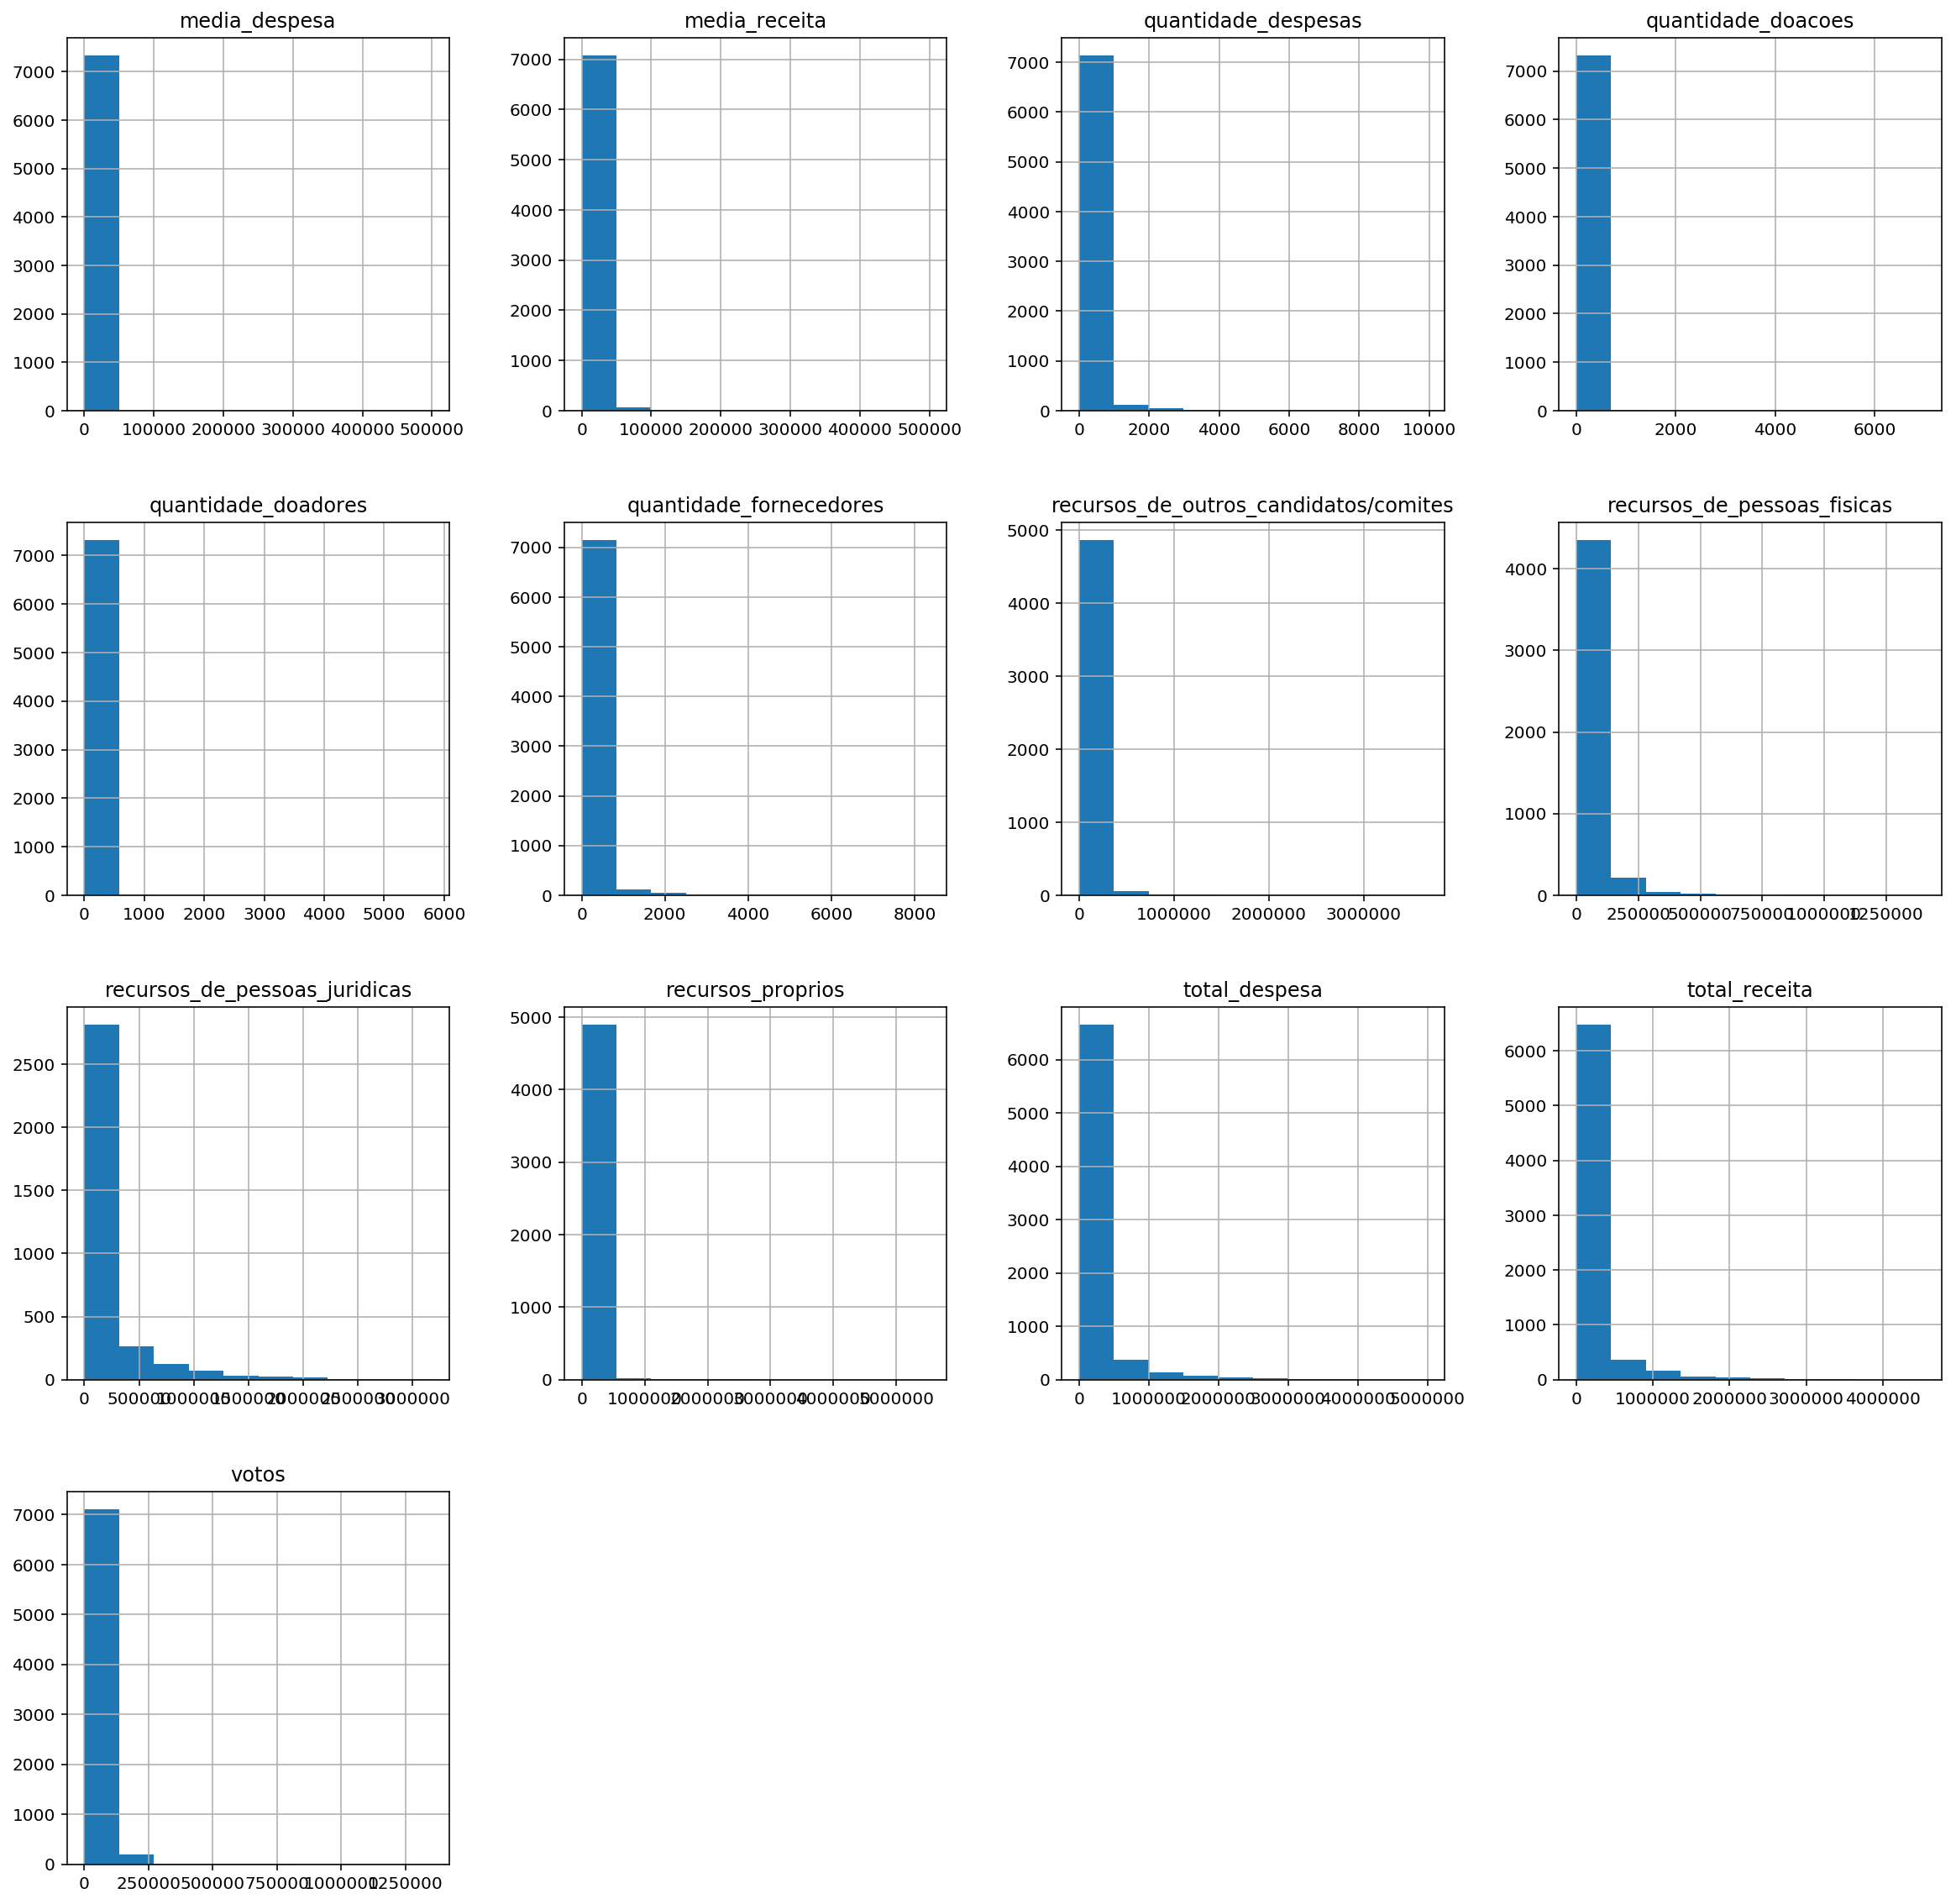

In [11]:
### Verificando a distribuição dos dados
df[df.dtypes[df.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

Verificamos através da visualização acima que as variáveis numéricas estão completamente enviesadas à esquerda.

Medidas como correlação ou regressão podem ser bastante influenciadas pelo pico da distribuição, outliers, dentre outros. 

Visando reduzir o efeito do viés nesses atributos aplicaremos uma transformação utilizando uma função logarítmica.

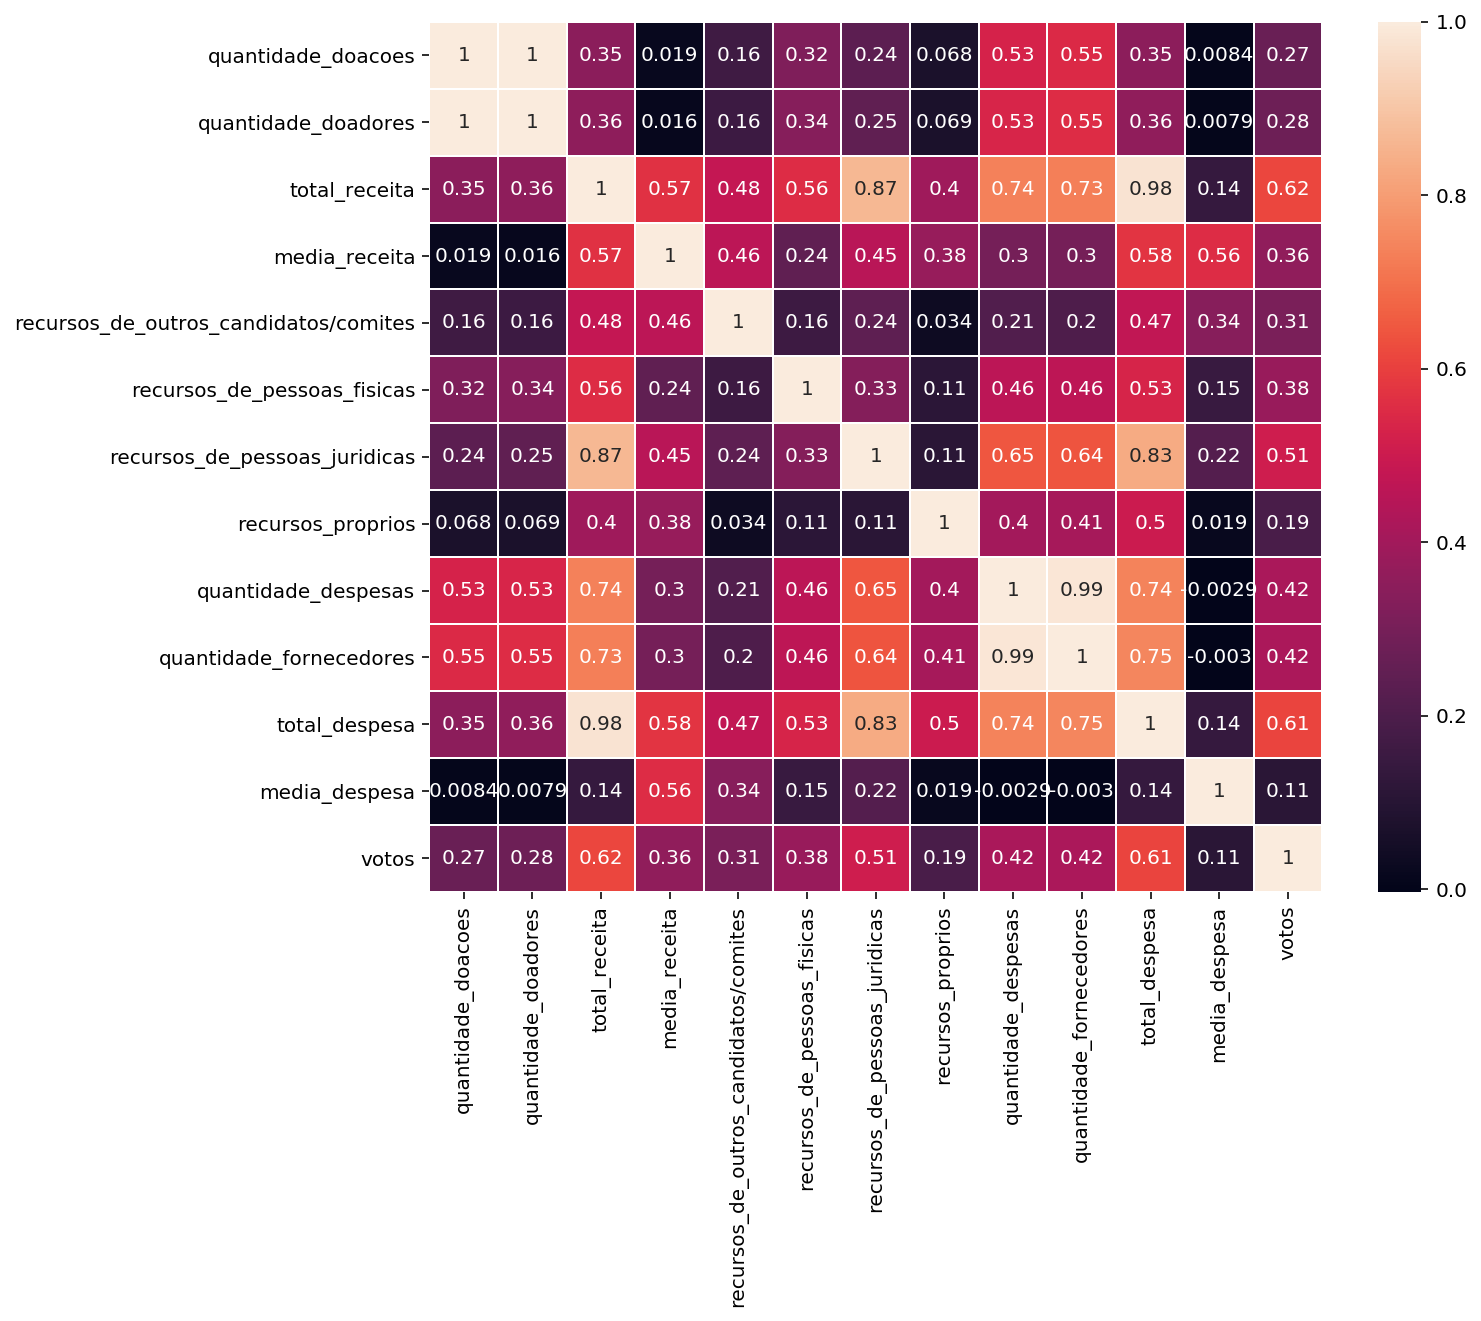

In [12]:
## Correlações entre os atributos numéricos
fig = plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2g', linewidths=.5)
plt.show()

#### Transformações

In [13]:
# Transformando a variável alvo com a função "log"
y = np.log1p(y)

# Transformando os atributos numéricos com a função "log"
## Separando os atributos numéricos
atributos_num = X.dtypes[X.dtypes != "object"].index
## Criando variáveis para os atributos categóricos
atributos_env = X[atributos_num].apply(lambda x: skew(x.dropna())) #compute skewness
atributos_env = atributos_env.index
## Transformando os atributos com a função "log"
X[atributos_env] = np.log1p(X[atributos_env])

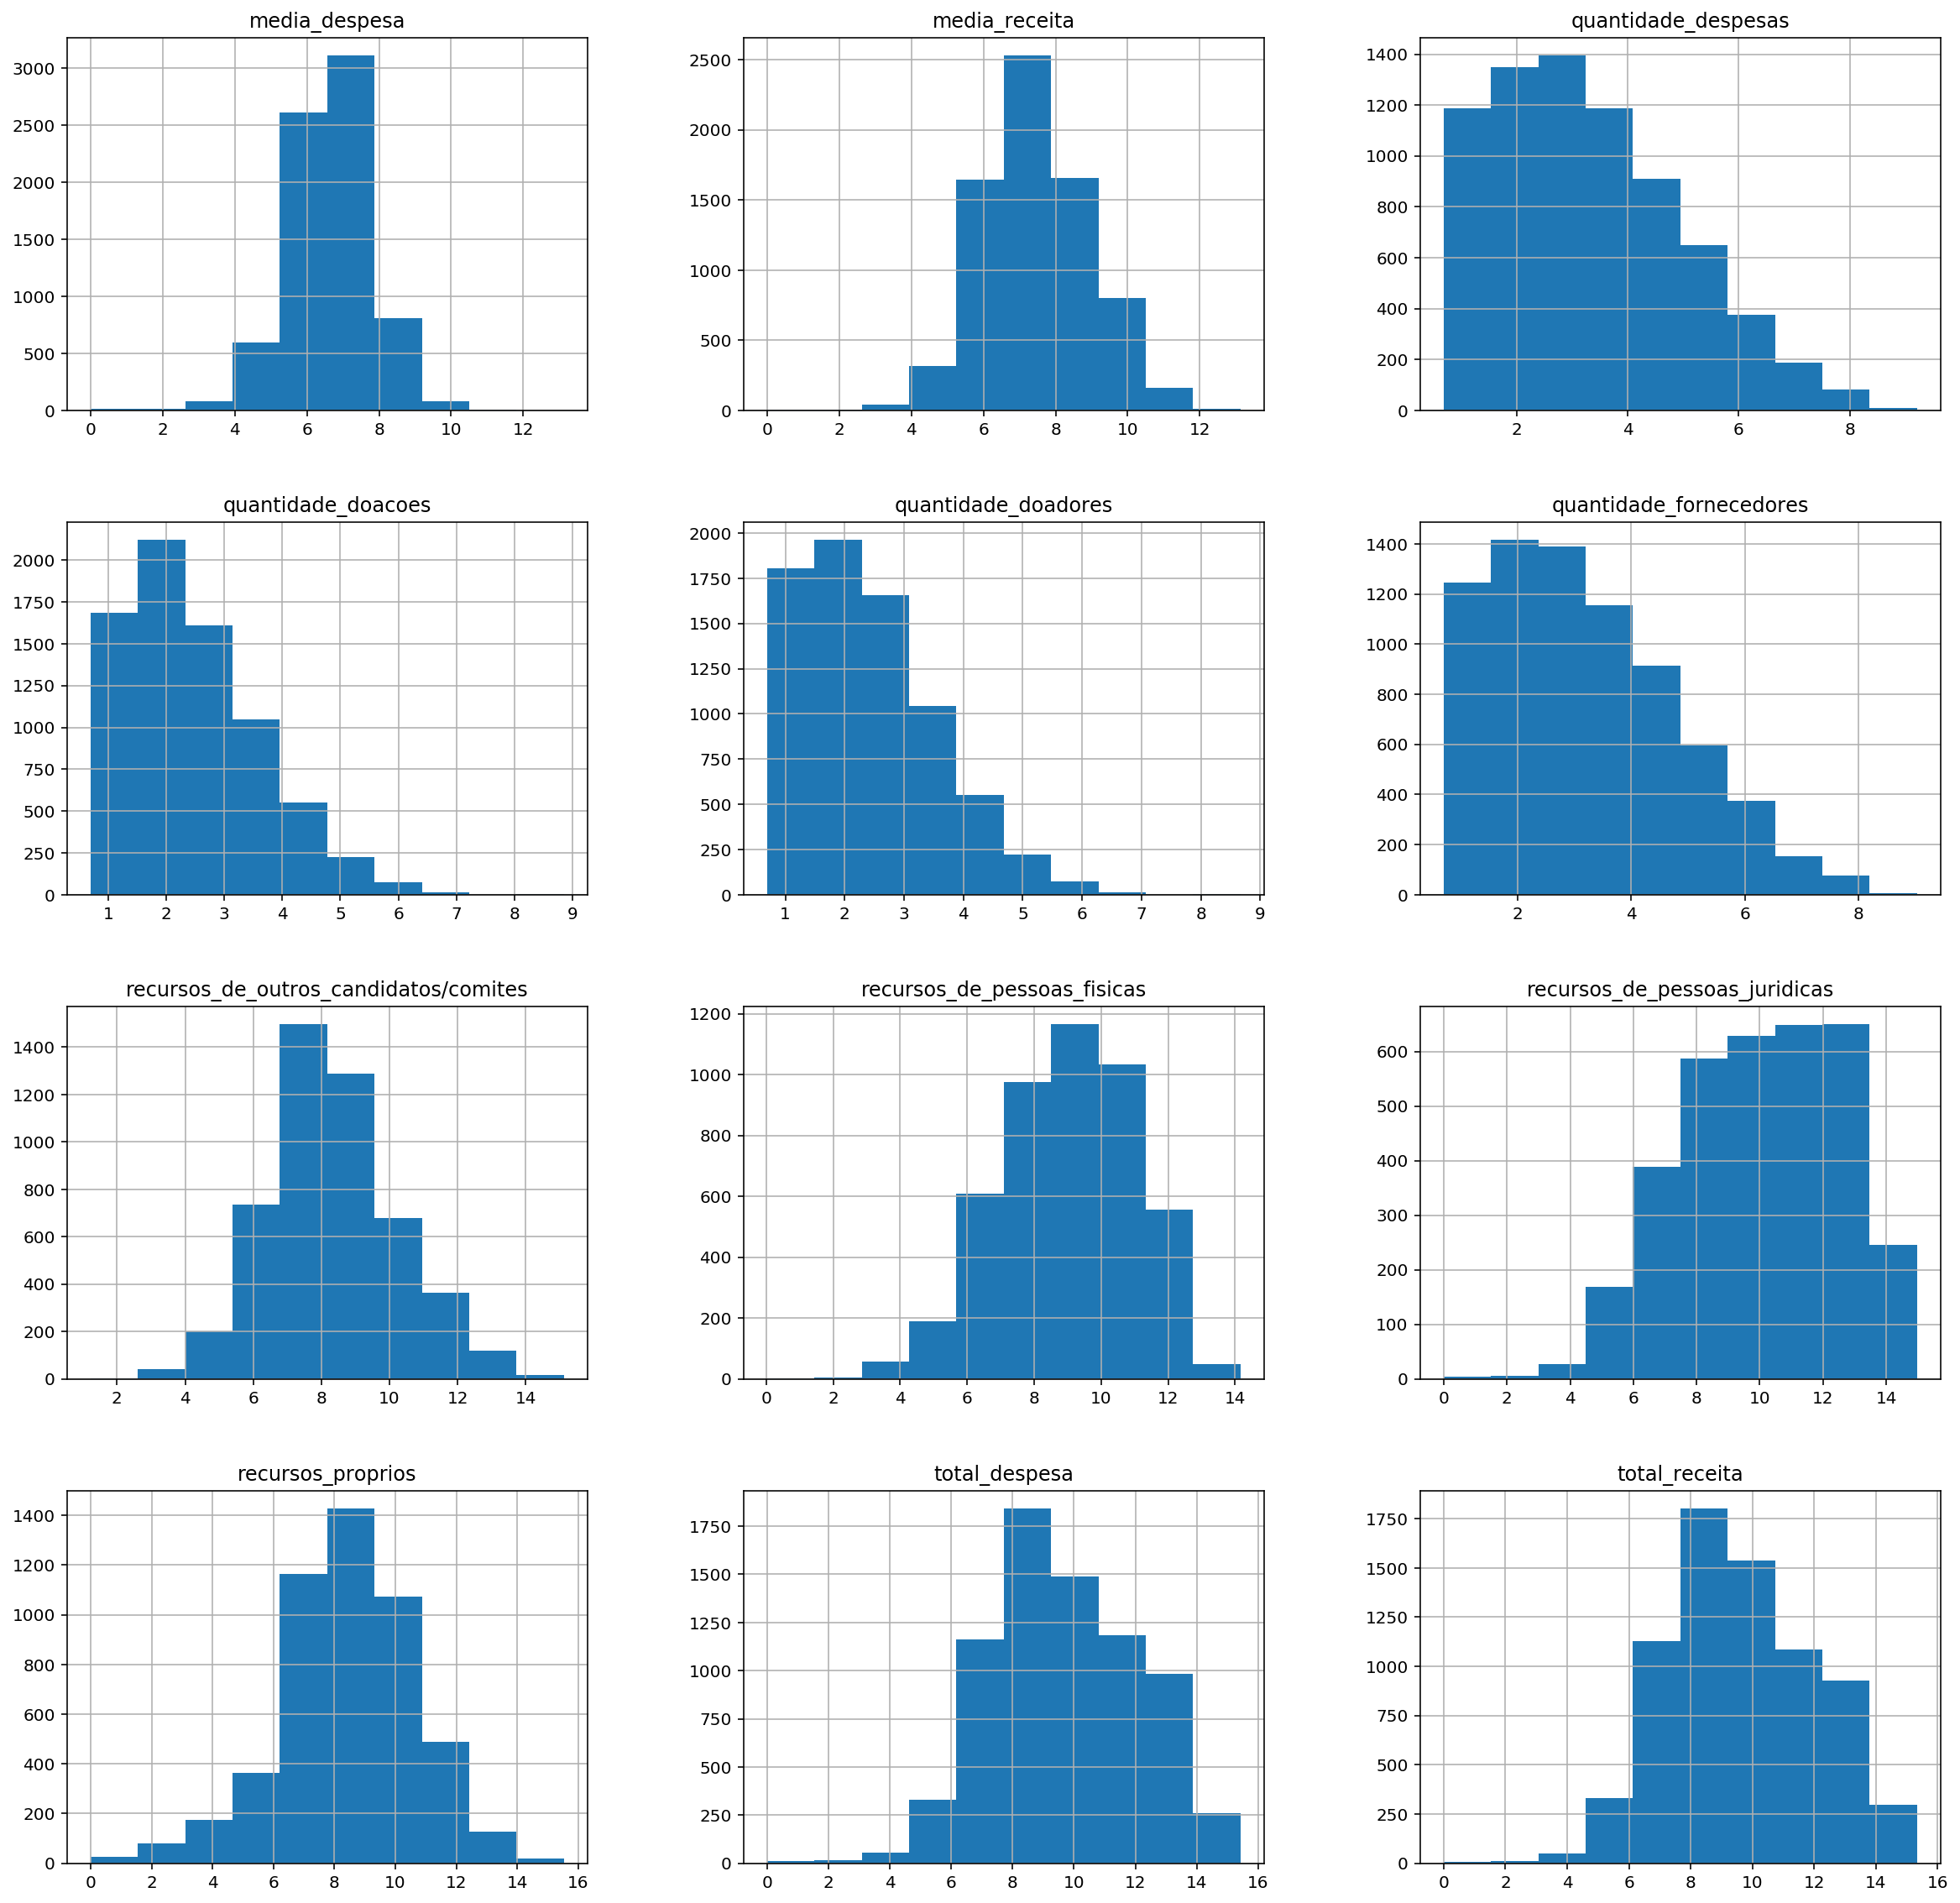

In [14]:
### Distribuição dos dados após transformações
X[X.dtypes[X.dtypes != "object"].index].hist(bins=10, figsize=(20, 20))
plt.show()

Verificamos que com a aplicação da função logarítmica a maior parte dos atributos estão menos enviesados, no entanto alguns desses atributos ainda apresentam algun enviesamento, como é o caso das quantidades de despesas, doações, doadores e fornecedores.

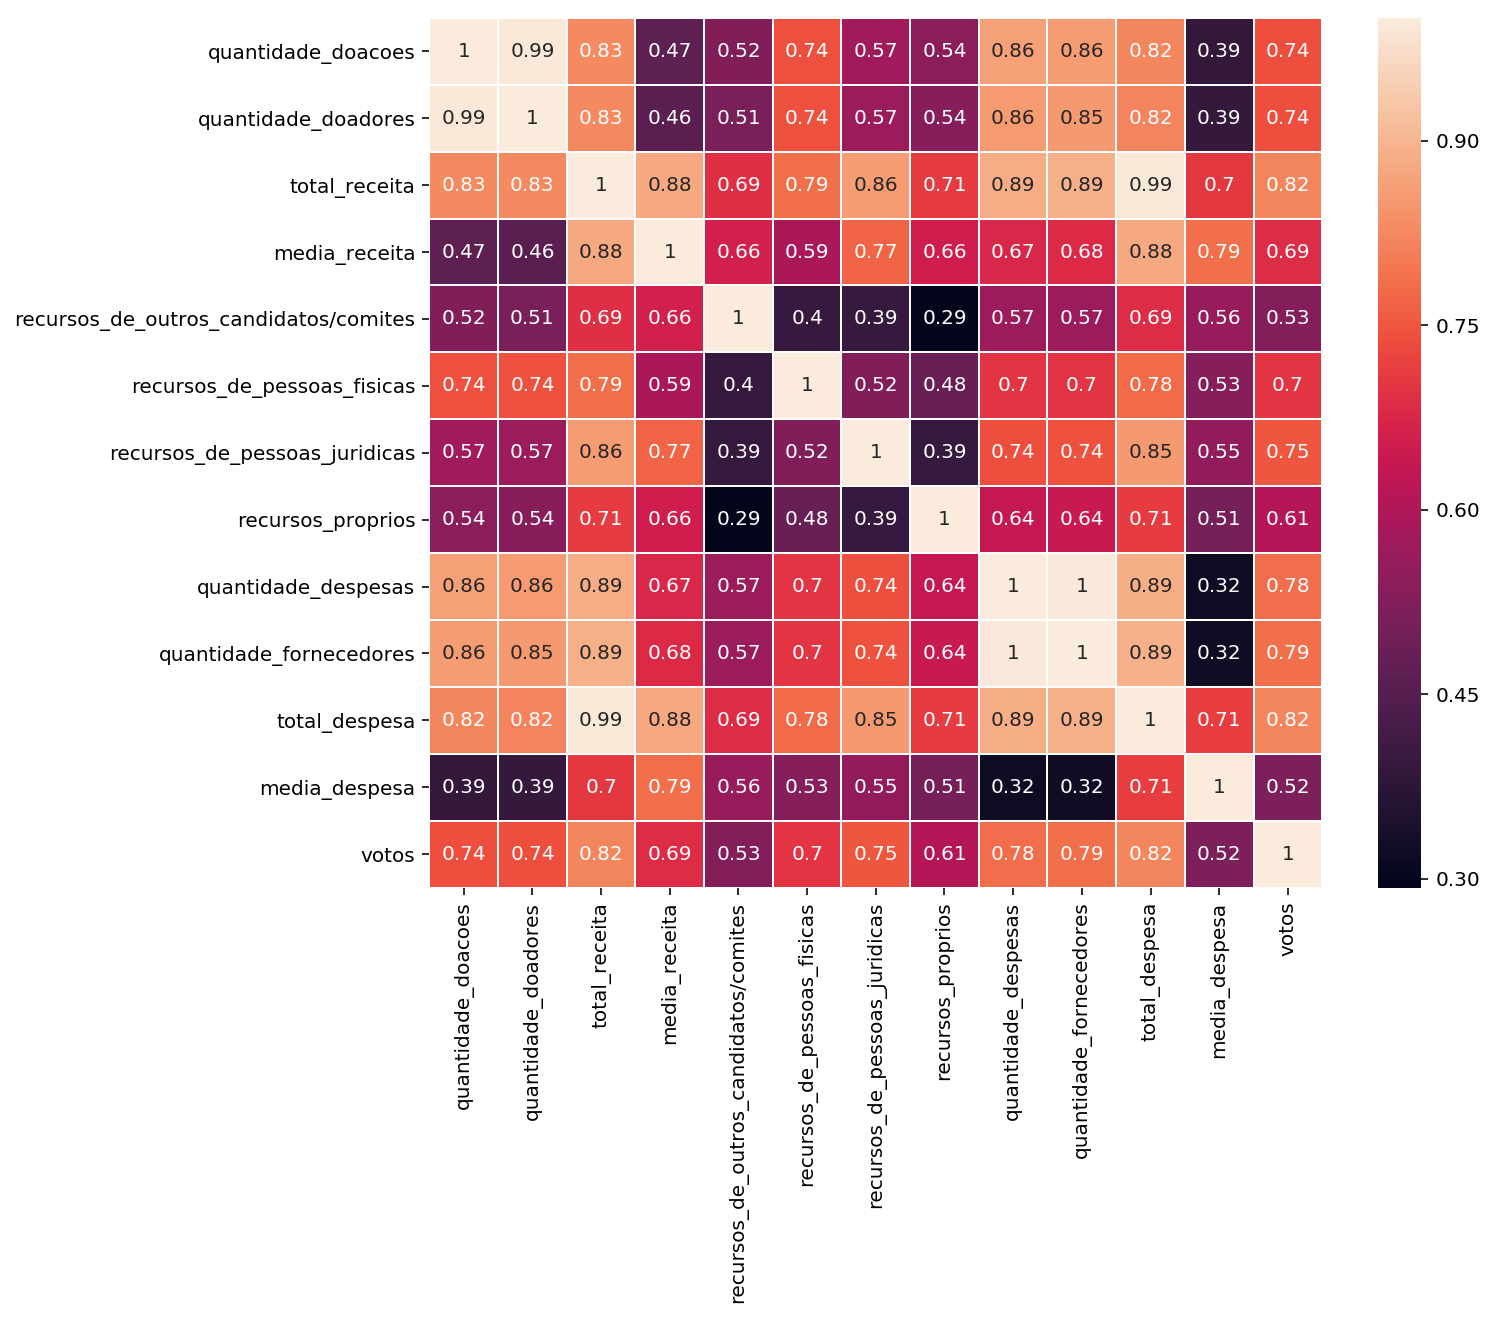

In [17]:
df_temp = pd.concat((train,test))

# Transformando os atributos numéricos com a função "log"
## Separando os atributos numéricos
atb_num = df_temp.dtypes[df_temp.dtypes != "object"].index
## Criando variáveis para os atributos categóricos
atb_env = df_temp[atb_num].apply(lambda x: skew(x.dropna())) #compute skewness
atb_env = atb_env.index
## Transformando os atributos com a função "log"
df_temp[atb_env] = np.log1p(df_temp[atb_env])

fig = plt.figure(figsize=(10,8))
sns.heatmap(df_temp.corr(), annot=True, fmt='.2g', linewidths=.5)
plt.show()

Após as transformações verificamos que a correlação entre os atributos numéricos e a variável alvo (votos) aumentou.

In [18]:
# Converter variáveis categóricas em variáveis indicadoras
X = pd.get_dummies(X)

In [19]:
# Preenchendo os valores faltantes com zero
X = X.fillna(0)

### Dividindo os dados em treino e teste

Os dados foram divididos considerando-se 60% para treino e 40% para testes

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

## Modelos

### Regressão Linear sem regularização

In [22]:
# Iportando as bibliotecas necessárias
from sklearn.linear_model import LinearRegression

In [23]:
# Parametrizando o modelo
lm = LinearRegression()

In [24]:
# Ajustando o modelo
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# Printando a intercepção
print(lm.intercept_)

367327713966.3767


In [26]:
# Printando os coeficientes
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df.head(10)

,Coefficient
quantidade_doacoes,0.051416
quantidade_doadores,0.593542
total_receita,-0.336630
media_receita,0.502820
recursos_de_outros_candidatos/comites,-0.007978
recursos_de_pessoas_fisicas,0.044898
recursos_de_pessoas_juridicas,0.058351
recursos_proprios,0.019292
quantidade_despesas,0.108593
quantidade_fornecedores,1.172241


#### Predições do modelo

Verificando as previsões no conjunto de testes

In [27]:
# Predição de instancias 
lm_predict = lm.predict(X_test)

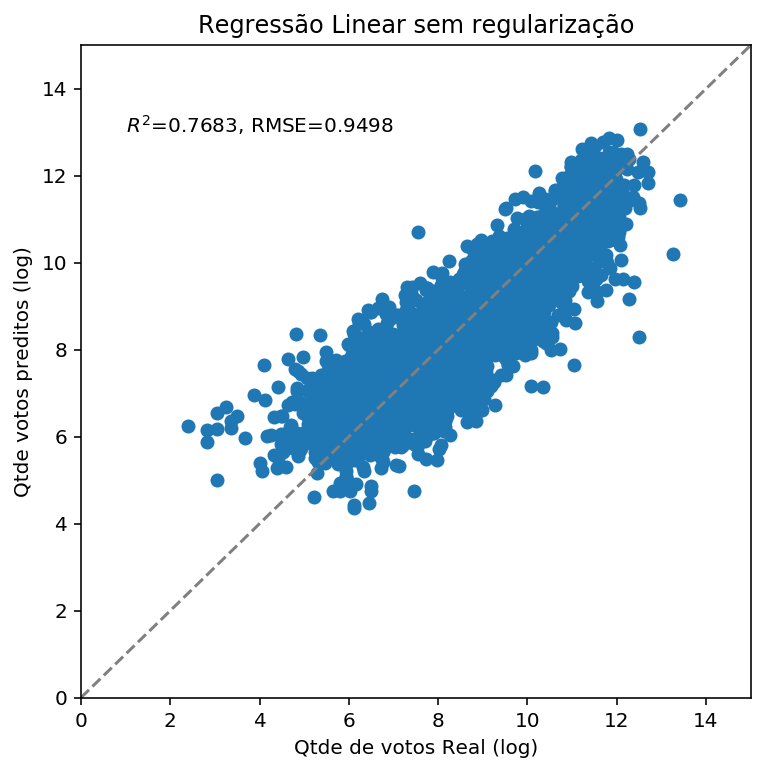

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lm_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear sem regularização')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, lm_predict), np.sqrt(metrics.mean_squared_error(y_test, lm_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

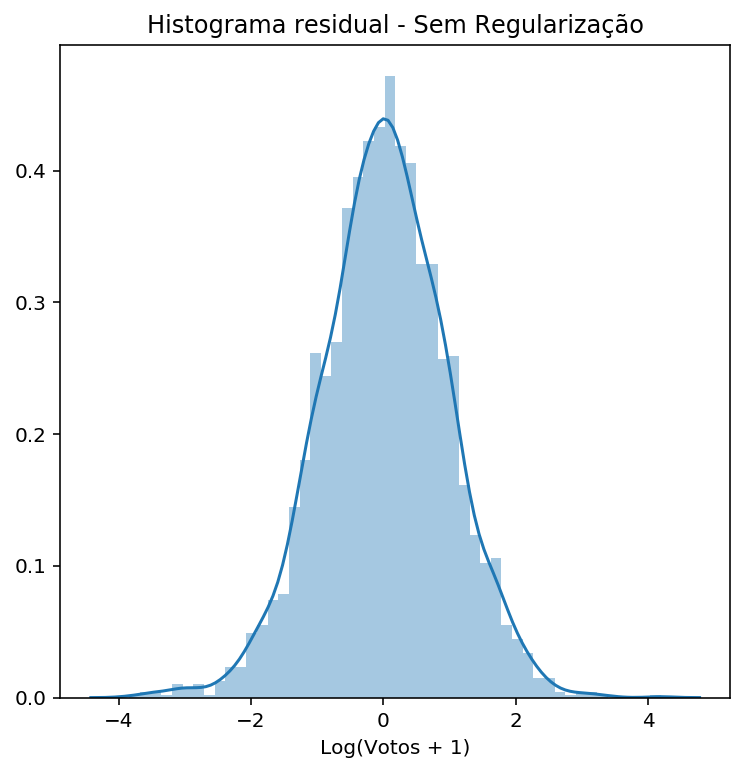

In [29]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - lm_predict),bins=50)
ax.set_title('Histograma residual - Sem Regularização')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

#### Metricas de avaliação do modelo

**Root Mean Square Error** (raiz do erro quadrático médio) (RMSE) é a raiz quadrada da média dos erros quadrados:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [30]:
# Computando o RMSE (Root Mean Square Error)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm_predict)))

RMSE: 0.9497802587582183


In [31]:
#Computando o RMSE (Root Mean Square Error) - Revertendo o log com a função exponencial
print('RMSE:', np.sqrt(metrics.mean_squared_error(np.expm1(y_test), np.expm1(lm_predict))))

RMSE: 32955.47671713665


**Coeficiente de Determinação ($R^2$)**

Uma das formas de avaliar a qualidade do ajuste do modelo é através do coeficiente de determinação. Basicamente, este coeficiente indica quanto o modelo foi capaz de explicar os dados coletados. O coeficiente de determinação é dado pela expressão

$$R^2=\frac{SSR}{SSTO}=1-\frac{SSE}{SSTO}$$, onde:

$$SSR=\sum_{i=1}^{n}(\hat{y}_i-\bar{y})^2$$

$$SSE=\sum_{i=1}^{n}(y_i-\hat{y}_i)^2$$

$$SSTO=\sum_{i=1}^{n}(y_i-\bar{y})^2$$

In [32]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, lm_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7683174748636059


Verificando o R2 acima o modelo consegue explicar 76,83% dos valores observados

### Regressão linear com regularização Ridge

In [33]:
# Iportando as bibliotecas necessárias
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [34]:
# Parametrizando o modelo
model_ridge = Ridge(alpha=5)

In [35]:
# Ajustando o modelo
model_ridge.fit(X_train,y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [36]:
# Printando a intercepção
print(model_ridge.intercept_)

2.6134047401261036


In [37]:
# Coeficente da regressão com regularização ridge
coef_ridge = pd.DataFrame(model_ridge.coef_,X_train.columns,columns=['Coefficient'])
coef_ridge.head(10)

,Coefficient
quantidade_doacoes,0.068976
quantidade_doadores,0.589239
total_receita,-0.350011
media_receita,0.521091
recursos_de_outros_candidatos/comites,-0.007651
recursos_de_pessoas_fisicas,0.044876
recursos_de_pessoas_juridicas,0.060478
recursos_proprios,0.018684
quantidade_despesas,0.134593
quantidade_fornecedores,0.887887


#### Predições do modelo

In [38]:
# Predição do modelo
ridge_predict = model_ridge.predict(X_test)

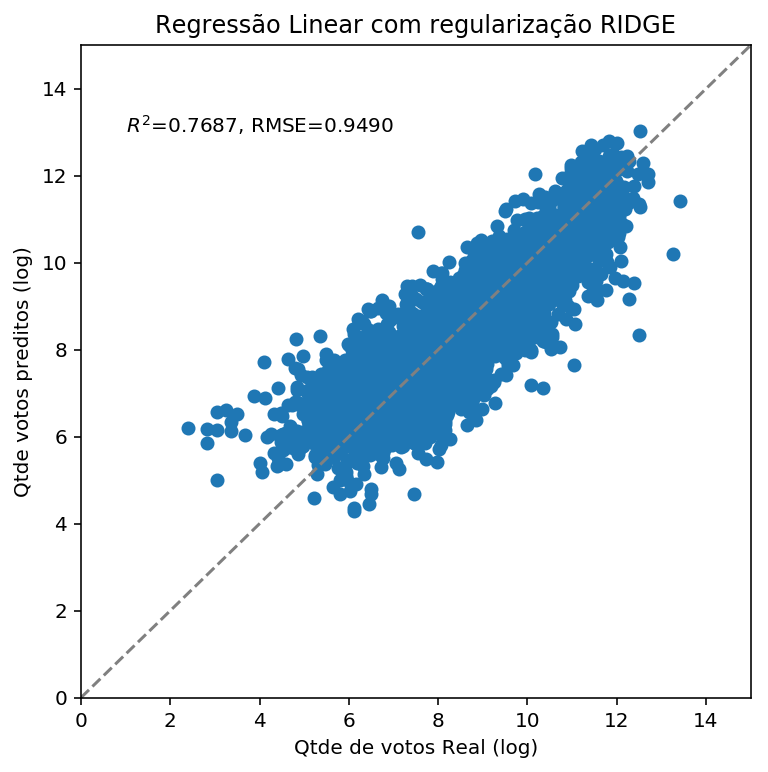

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, ridge_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear com regularização RIDGE')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, ridge_predict), np.sqrt(metrics.mean_squared_error(y_test, ridge_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

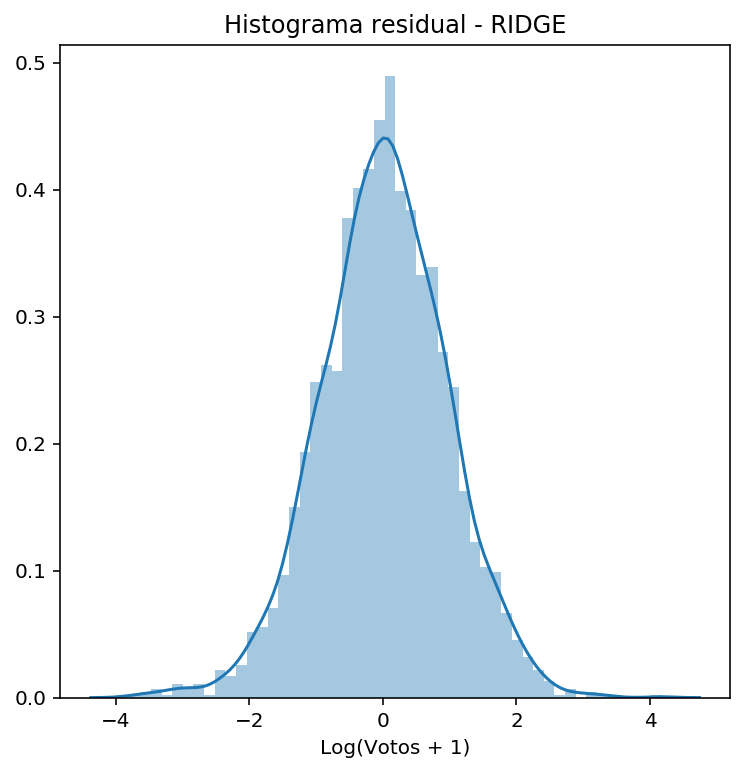

In [40]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - ridge_predict),bins=50)
ax.set_title('Histograma residual - RIDGE')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

##### Metricas de avaliação do modelo

In [41]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_predict)))

RMSE: 0.9489998785285962


In [42]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, ridge_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7686980390705128


O principal parâmetro de ajuste para o modelo Ridge é alpha - um parâmetro de regularização que mede quão flexível é nosso modelo. Quanto maior a regularização, menos propenso será o nosso modelo de overfit. No entanto, também perderá a flexibilidade e poderá não capturar todo o sinal nos dados.

In [43]:
alphas = [0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

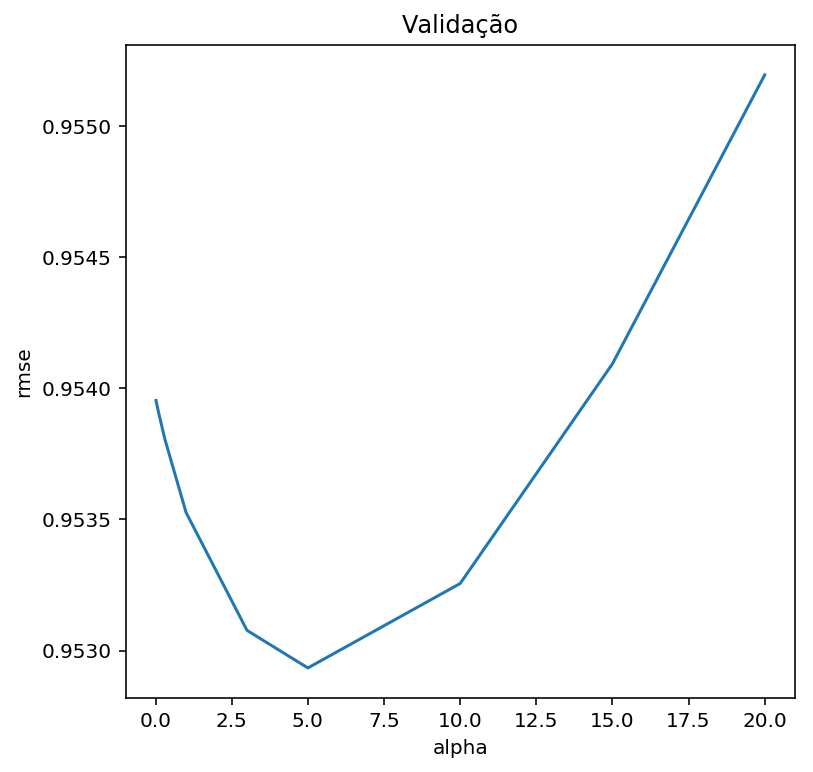

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

Observe a curva em forma de U acima. Quando alfa é muito grande, a regularização é muito forte e o modelo não consegue capturar todas as complexidades dos dados. Se, no entanto, deixarmos o modelo ser muito flexível (alfa pequeno), o modelo começa a se sobrepor. Um valor de alfa = 10 é quase certo com base no gráfico acima.

In [45]:
cv_ridge.min()

0.9529334692601521

Para a regressão de Ridge, obtivemos um RMSE de cerca de 0,947

### Regressão linear com regularização Lasso

In [46]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=10000).fit(X_train, y_train)

In [47]:
rmse_cv(model_lasso).mean()

0.9533504297515574

In [48]:
# Printando a intercepção
print(model_lasso.intercept_)

2.7111779563269813


In [49]:
# Coeficientes da regressão com regularização lasso
coef_lasso = pd.DataFrame(model_lasso.coef_, index = X_train.columns, columns=['Coefficient'])
coef_lasso.head(10)

,Coefficient
quantidade_doacoes,0.040191
quantidade_doadores,0.587111
total_receita,-0.328817
media_receita,0.489300
recursos_de_outros_candidatos/comites,-0.007769
recursos_de_pessoas_fisicas,0.044839
recursos_de_pessoas_juridicas,0.059667
recursos_proprios,0.018832
quantidade_despesas,0.108211
quantidade_fornecedores,1.042395


In [50]:
# R-quadraro para o modelo com regularização ridge
model_lasso.score(X_train,y_train)

0.7785785143321863

In [51]:
# Predição do modelo
lasso_predict = model_lasso.predict(X_test)

In [52]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_predict)))

RMSE: 0.9486114571684503


In [161]:
# Coeficiente de determinação (R²)
print('R²:',metrics.r2_score(y_test, lasso_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7688873420160903


In [54]:
# Coeficientes da regressão com regularização lasso
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

Uma coisa interessante sobre o Lasso é que ele apresenta seleção para você - definindo coeficientes de recursos que ele considera sem importância para zero. Vamos dar uma olhada nos coeficientes:

In [55]:
print("O Lasso selecionou " + str(sum(coef_lasso != 0)) + " variaveis e eliminou outras " +  str(sum(coef_lasso == 0)) + " variables")

O Lasso selecionou 74 variaveis e eliminou outras 11 variables


Podemos também dar uma olhada diretamente nos coeficientes mais importantes:

In [56]:
# Selecionando os 10 primeiros e os 10 últimos coeficientes
imp_coef_lasso = pd.concat([coef_lasso.sort_values().head(10),
                     coef_lasso.sort_values().tail(10)])

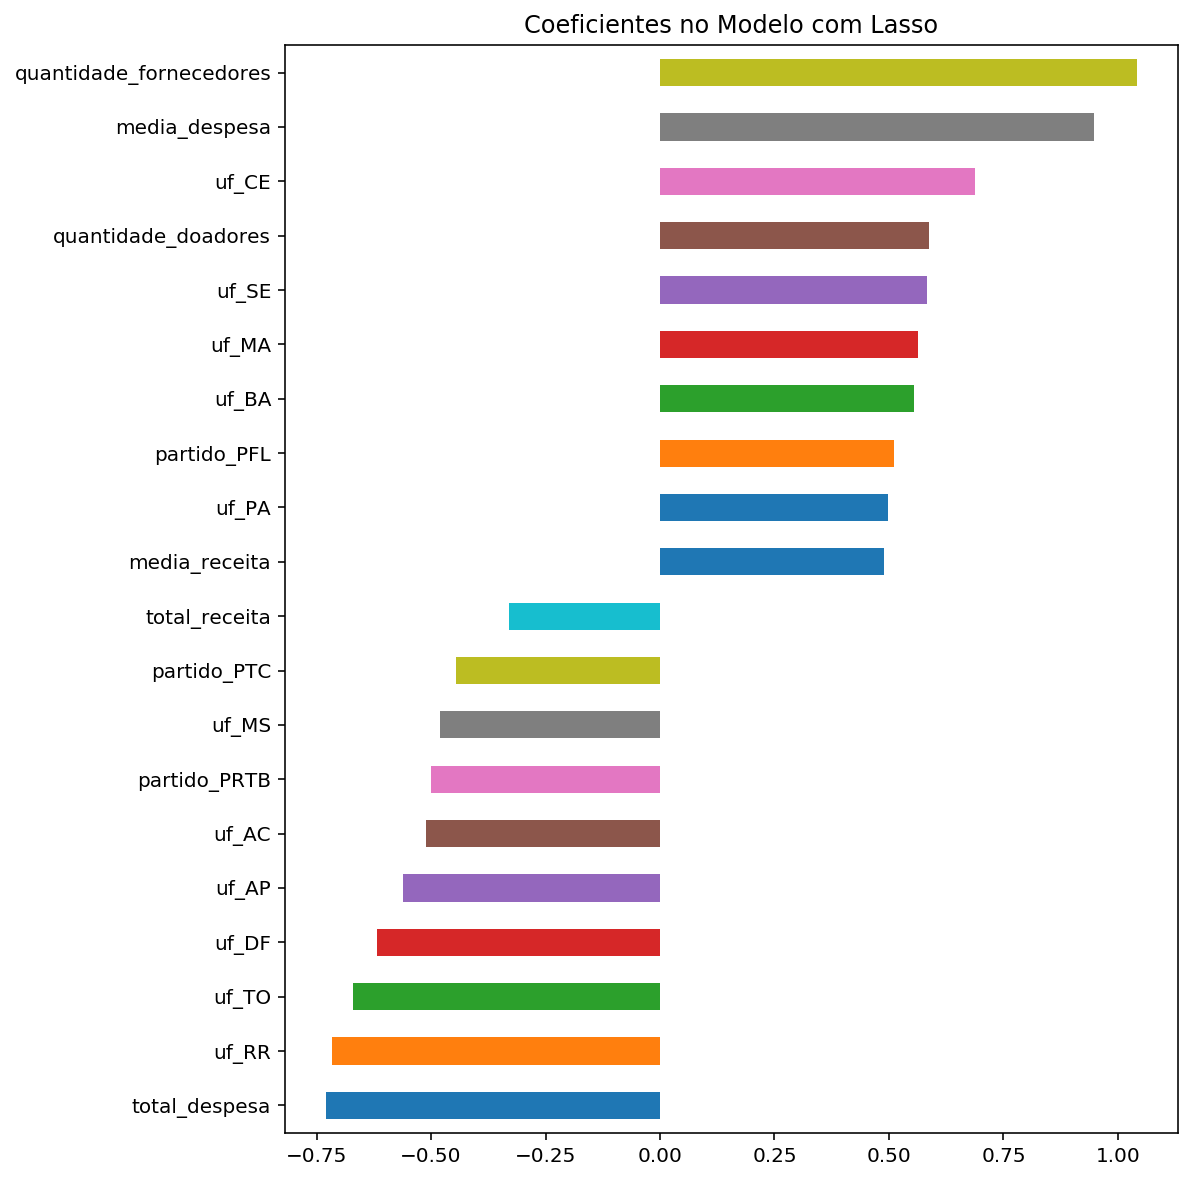

In [57]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef_lasso.plot(kind = "barh")
plt.title("Coeficientes no Modelo com Lasso")
plt.show()

Podemos perceber pela visualização acima que o atributo mais importante é `quantidade_fornecedores` seguido da `media_despesa`.

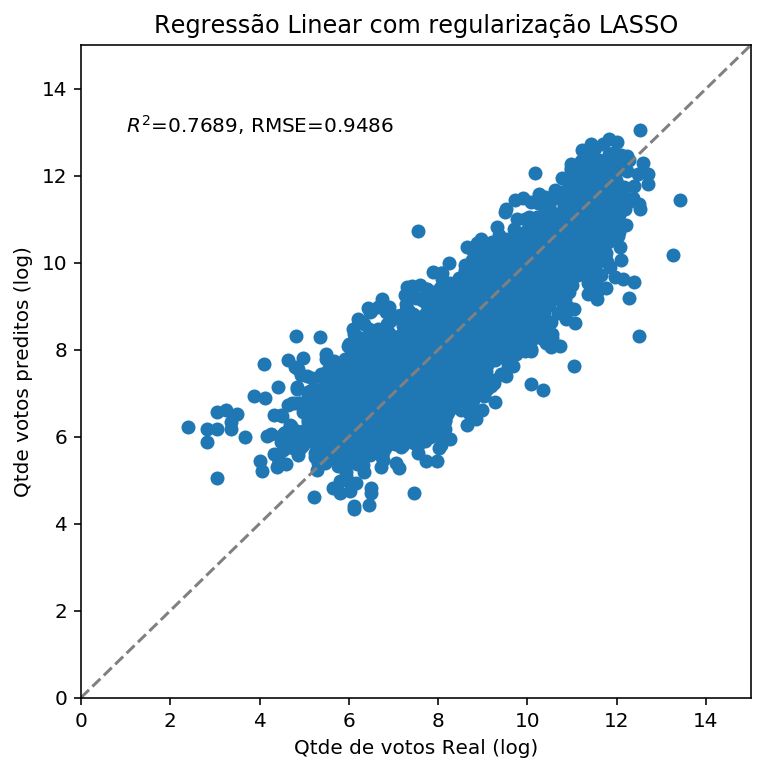

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lasso_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear com regularização LASSO')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, lasso_predict), np.sqrt(metrics.mean_squared_error(y_test, lasso_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

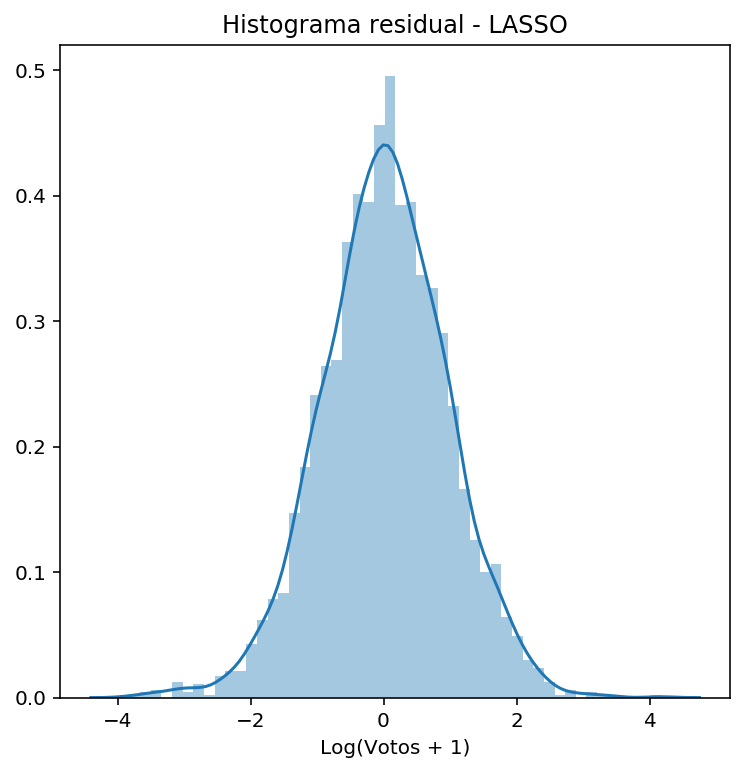

In [59]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - lasso_predict),bins=50)
ax.set_title('Histograma residual - LASSO')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

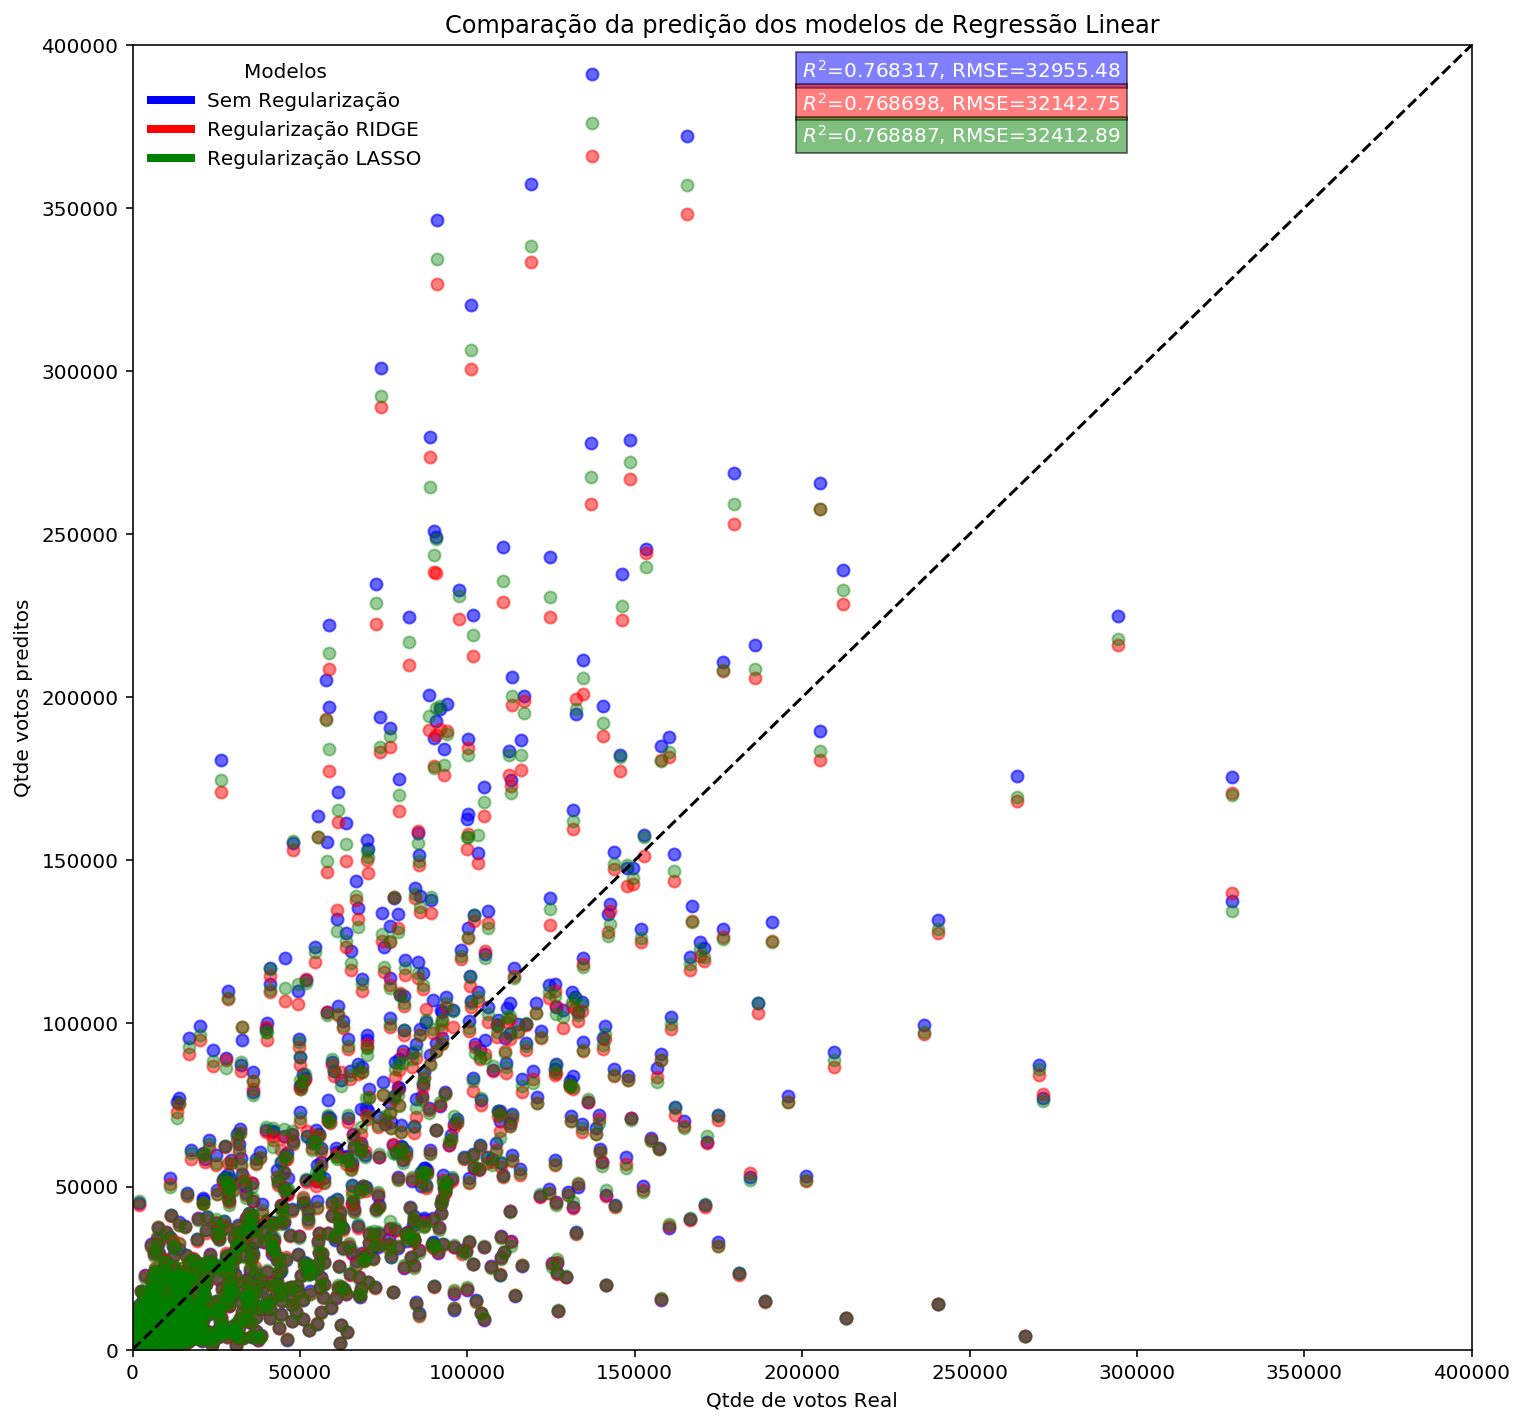

In [160]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(np.expm1(y_test), np.expm1(lm_predict), c='b', alpha=0.6)
ax.scatter(np.expm1(y_test), np.expm1(ridge_predict), c='r', alpha=0.5)
ax.scatter(np.expm1(y_test), np.expm1(lasso_predict), c='g', alpha=0.4)
ax.plot([0, 400000], [0, 400000], '--k')
ax.set_ylabel('Qtde votos preditos')
ax.set_xlabel('Qtde de votos Real')
ax.set_title('Comparação da predição dos modelos de Regressão Linear')
ax.text(200000, 390000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, lm_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(lm_predict)))), bbox={'facecolor': 'b', 'alpha': 0.5, 'pad': 3}, color='w')
ax.text(200000, 380000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, ridge_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(ridge_predict)))), bbox={'facecolor': 'r', 'alpha': 0.5, 'pad': 3}, color='w')
ax.text(200000, 370000, r'$R^2$=%.6f, RMSE=%.2f' % (
    metrics.r2_score(y_test, lasso_predict), np.sqrt(metrics.mean_squared_error(np.expm1(y_test), \
    np.expm1(lasso_predict)))), bbox={'facecolor': 'g', 'alpha': 0.5, 'pad': 3}, color='w')
ax.set_xlim([0, 400000])
ax.set_ylim([0, 400000])
# Legendas
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax.legend(custom_lines, ["Sem Regularização","Regularização RIDGE", "Regularização LASSO"], \
           title="Modelos", frameon=False, loc='upper left')
plt.show()

Pela visualização acima verificamos que as regresões lineares tiveram um desempenho parecido com $R^2$ um pouco maior para a Regressão linear com regularização LASSO e RMSE menor para a Regressão Linear com regularização RIDGE.

###  KNN Regressor

In [61]:
from sklearn.neighbors import KNeighborsRegressor

In [62]:
knn = KNeighborsRegressor(n_neighbors=8,weights='uniform',p=2)

In [63]:
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')

In [64]:
knn_predict = knn.predict(X_test)

In [66]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, knn_predict)))

RMSE: 1.0012312716097589


In [163]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, knn_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7425364150998915


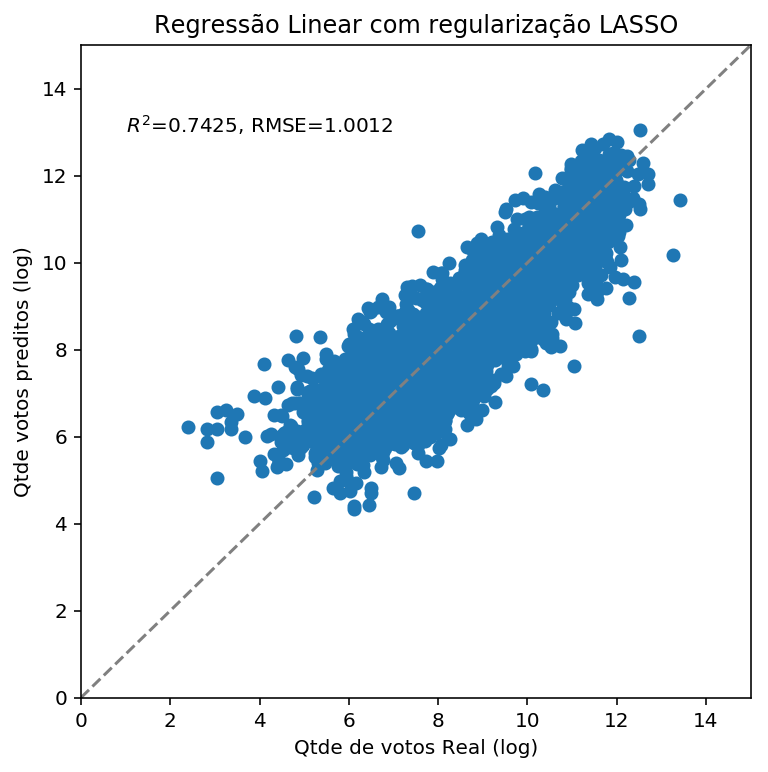

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, lasso_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Regressão Linear com regularização LASSO')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, knn_predict), np.sqrt(metrics.mean_squared_error(y_test, knn_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

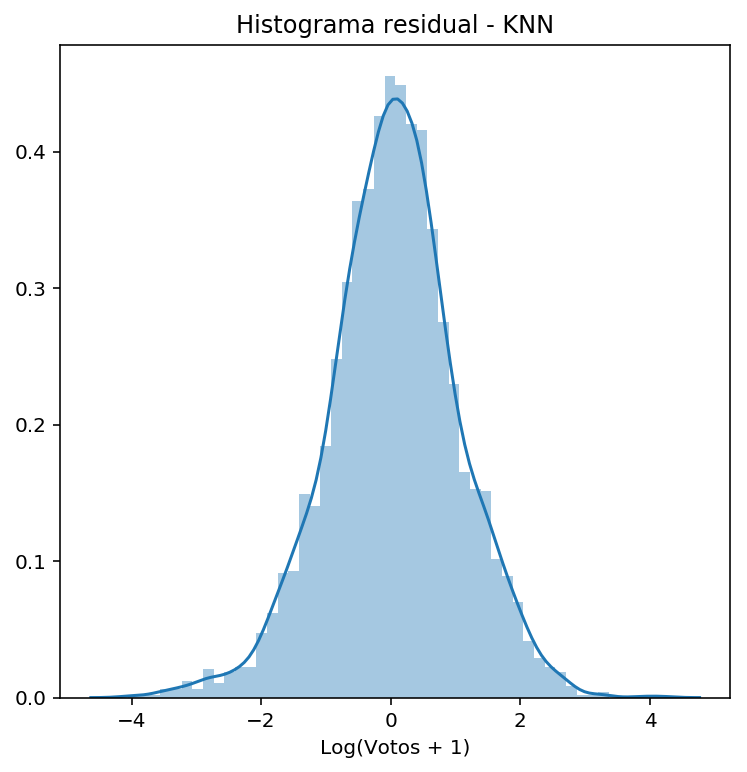

In [68]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - knn_predict),bins=50)
ax.set_title('Histograma residual - KNN')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

O KNN Regressor teve um desempenho menor que as Regressões Lineares, com $R^2$ = 0.742536 e RMSE = 1.0012312716097589

### Random Forest Regressor

In [69]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

In [70]:
# Instantiate model with 100 decision trees
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)

In [71]:
# Train the model on training data
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
# Use the forest's predict method on the test data
rfr_predict = rfr.predict(X_test)

In [97]:
# Calculate the absolute errors
errors = abs(y_test - rfr_predict)

In [172]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', np.mean(errors))

Mean Absolute Error: 0.7299339175342557


In [98]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_predict)))

RMSE: 0.9414205719737669


In [164]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, rfr_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.772377929443089


In [102]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

In [103]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.31 %.


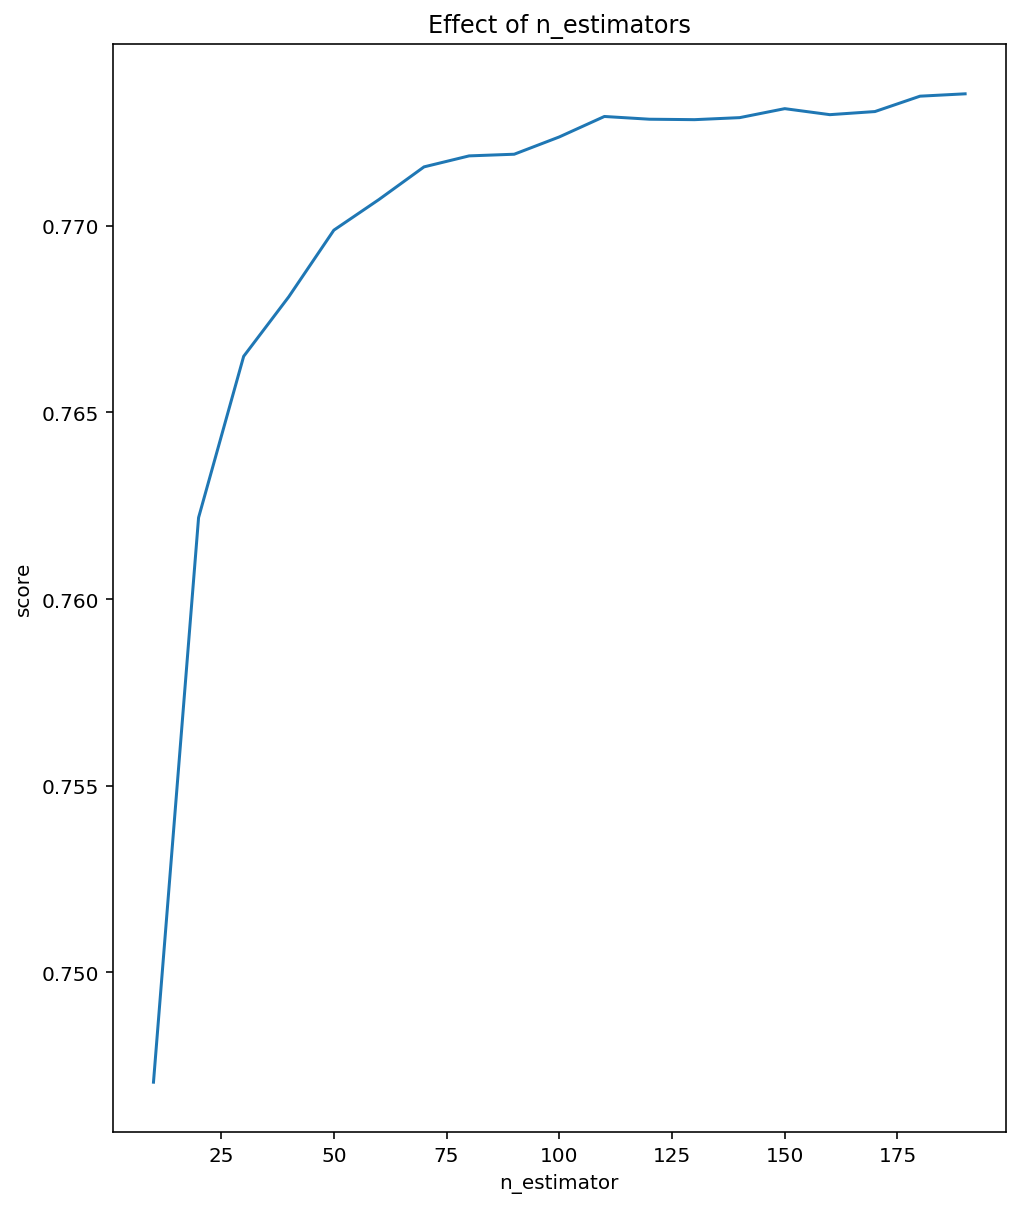

In [104]:
# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    rfr.set_params(n_estimators=n)
    rfr.fit(X_train, y_train)
    scores.append(rfr.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

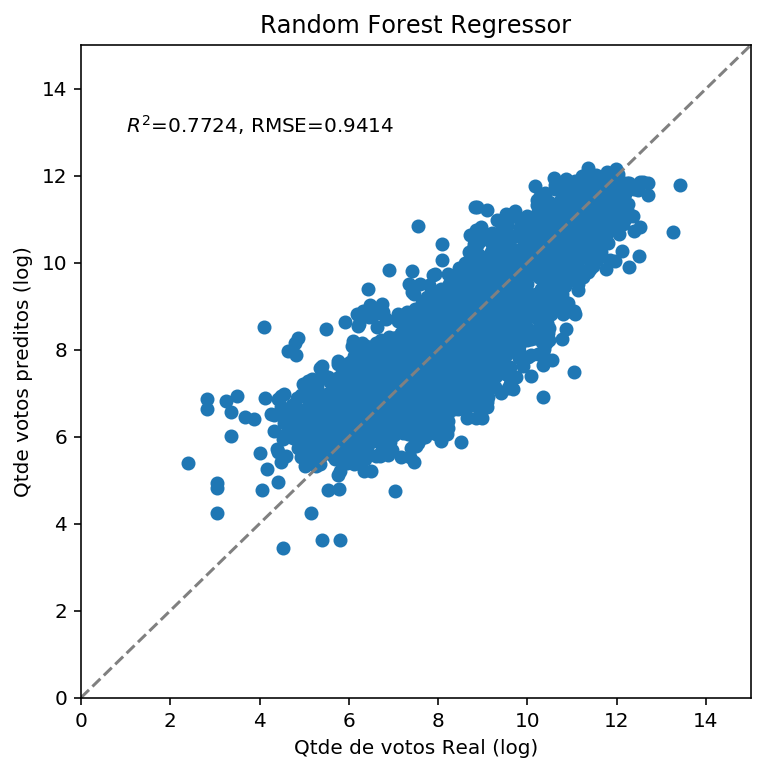

In [157]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, rfr_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Random Forest Regressor')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, rfr_predict), np.sqrt(metrics.mean_squared_error(y_test, rfr_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

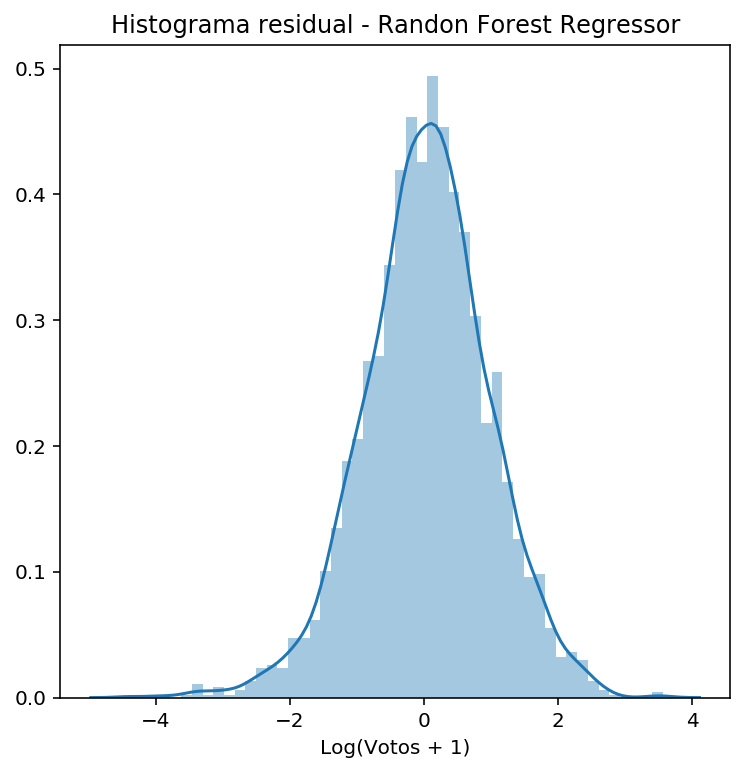

In [158]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - rfr_predict),bins=50)
ax.set_title('Histograma residual - Randon Forest Regressor')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Modelo SVR

In [105]:
from sklearn.svm import SVR

In [106]:
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=1.0)
#svr_model = SVR(kernel='linear', C=1e3, gamma=0.1, epsilon=1.0)

In [107]:
svr_model.fit(X_train,y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.0, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [108]:
svr_predict = svr_model.predict(X_test)

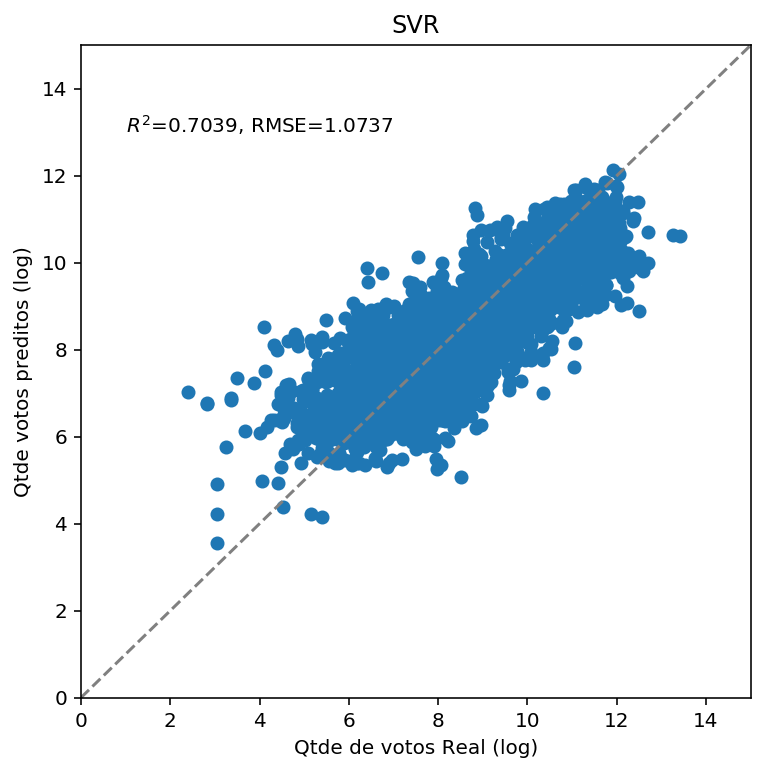

In [151]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, svr_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('SVR')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, svr_predict), np.sqrt(metrics.mean_squared_error(y_test, svr_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

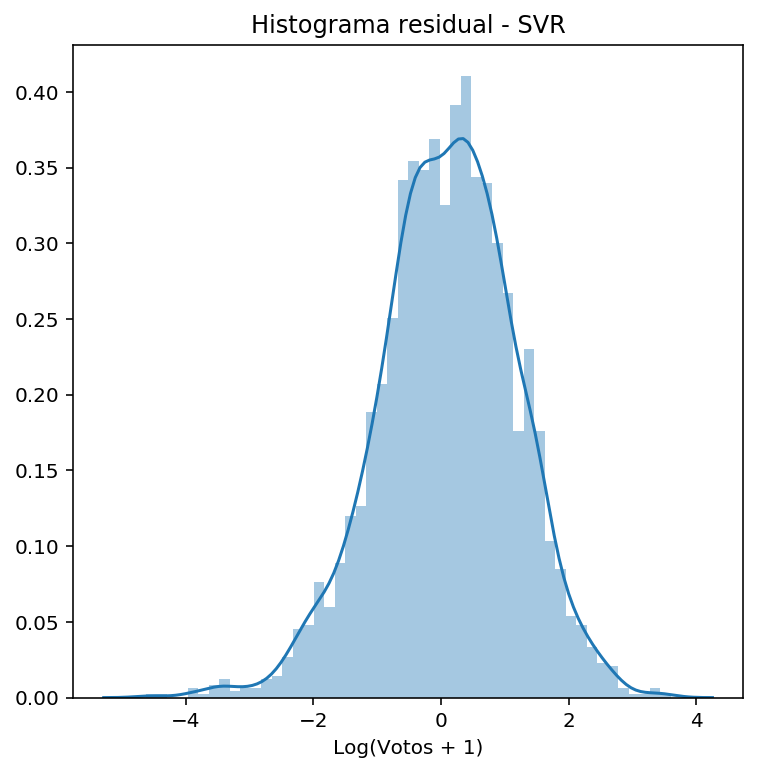

In [149]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - svr_predict),bins=50)
ax.set_title('Histograma residual - SVR')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

In [111]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_predict)))

RMSE: 1.0737196697226516


In [166]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, svr_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7039065370992588


### Regression trees

In [126]:
# Iportando o modelo de árvore de regressão
from sklearn.tree import DecisionTreeRegressor

In [140]:
# Parametrizando o modelo
rt_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=100)

In [141]:
# Ajustando o modelo
rt_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=100,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [142]:
# Predição de instancias 
rt_predict = rt_model.predict(X_test)

In [143]:
# Root Mean Square Error
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rt_predict)))

RMSE: 1.005743869697156


In [167]:
# Coeficiente de determinação (R²)
print('R²:', metrics.r2_score(y_test, rt_predict, sample_weight=None,multioutput="uniform_average"))

R²: 0.7402103832922939


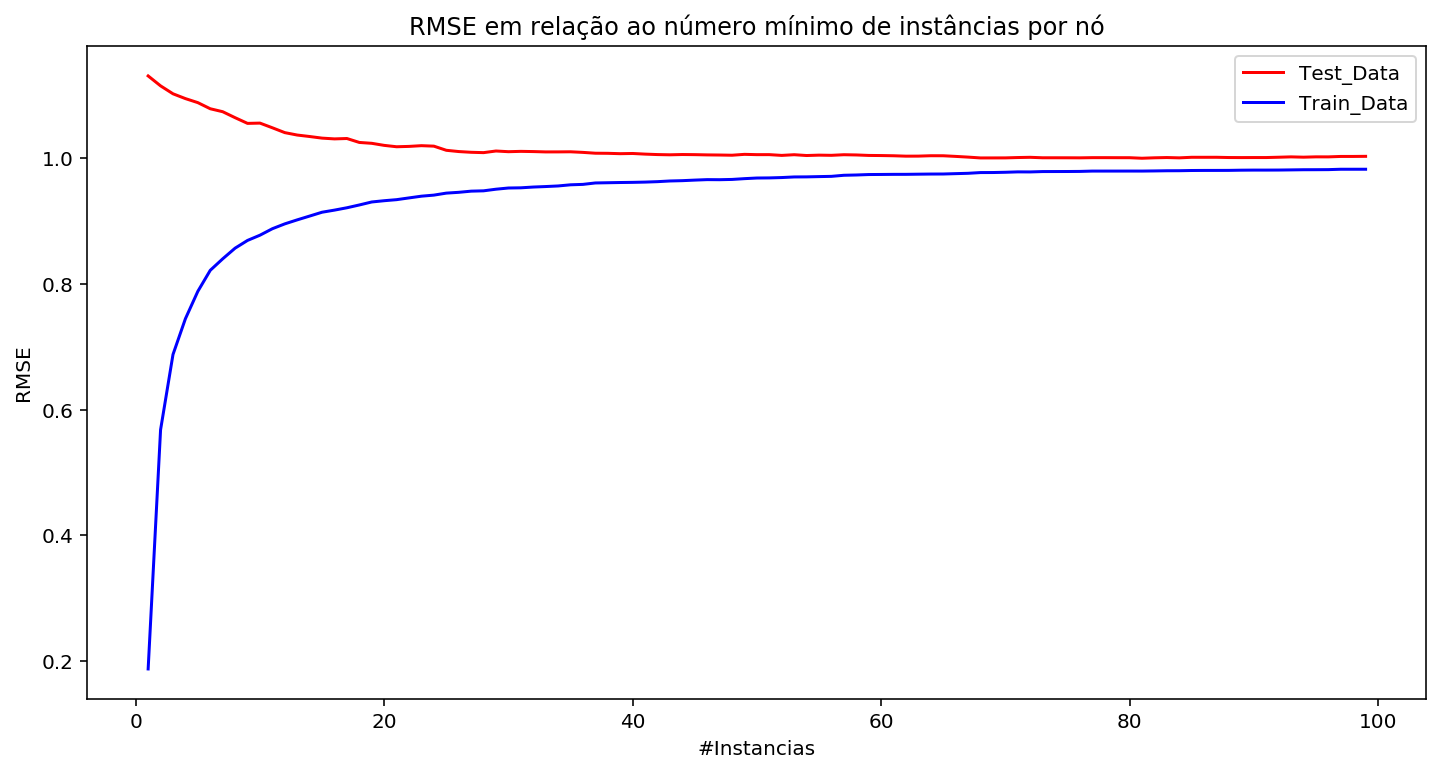

In [145]:
"""
Plotar o RMSE em relação ao número mínimo de instâncias
""" 
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(111) 
RMSE_train = []
RMSE_test = []
for i in range(1,100):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    rt_model = DecisionTreeRegressor(criterion="mse",min_samples_leaf=i)   
    #Train the model
    rt_model.fit(X_train,y_train)
    #Predict query instances
    predicted_train = rt_model.predict(X_train)
    predicted_test = rt_model.predict(X_test)
    #Calculate and append the RMSEs
    RMSE_train.append(np.sqrt(np.sum(np.sqrt(metrics.mean_squared_error(y_train, predicted_train)))))
    RMSE_test.append(np.sqrt(np.sum(np.sqrt(metrics.mean_squared_error(y_test, predicted_test)))))
   
ax0.plot(range(1,100),RMSE_test,label='Test_Data', color='r')
ax0.plot(range(1,100),RMSE_train,label='Train_Data', color='b')
ax0.legend()
ax0.set_title('RMSE em relação ao número mínimo de instâncias por nó')
ax0.set_xlabel('#Instancias')
ax0.set_ylabel('RMSE')
plt.show()

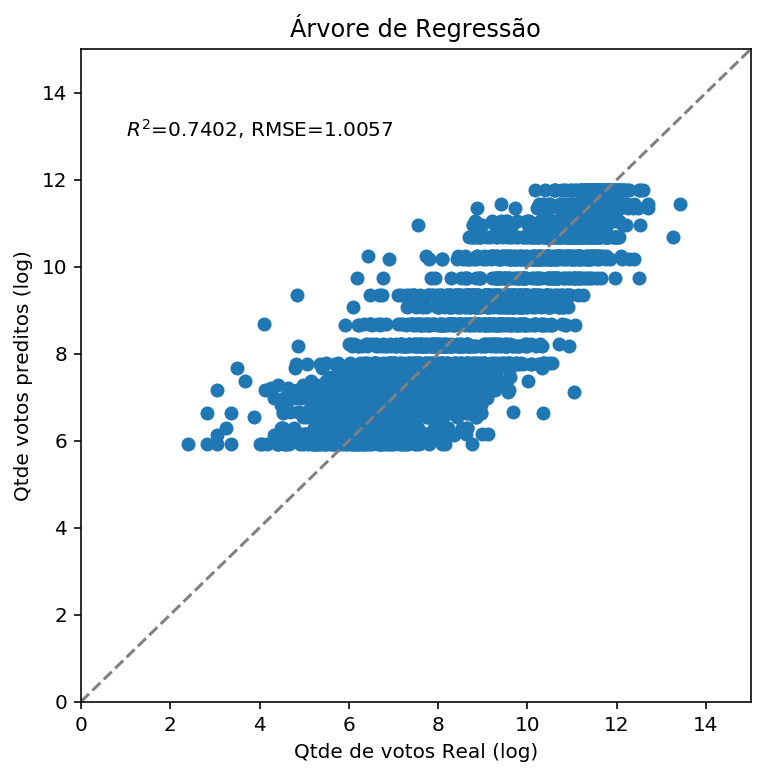

In [155]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, rt_predict)
ax.plot([0, 15], [0, 15], '--k', c='gray')
ax.set_ylabel('Qtde votos preditos (log)')
ax.set_xlabel('Qtde de votos Real (log)')
ax.set_title('Árvore de Regressão')
ax.text(1, 13, r'$R^2$=%.4f, RMSE=%.4f' % (
    metrics.r2_score(y_test, rt_predict), np.sqrt(metrics.mean_squared_error(y_test, rt_predict))))
ax.set_xlim([0, 15])
ax.set_ylim([0, 15])

plt.show()

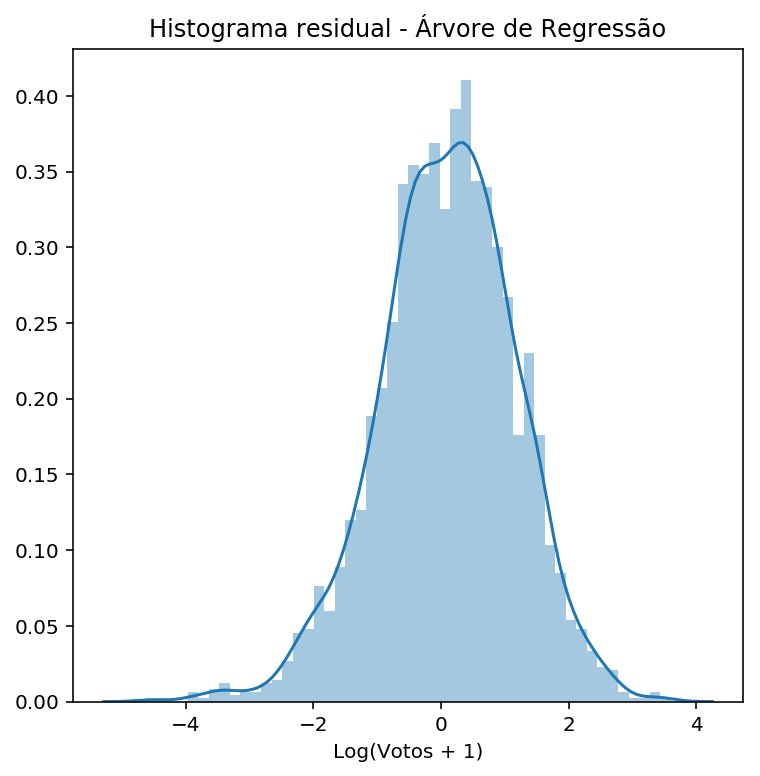

In [156]:
### Histograma residual
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot((y_test - svr_predict),bins=50)
ax.set_title('Histograma residual - Árvore de Regressão')
ax.set_xlabel('Log(Votos + 1)')
plt.show()

### Conclusão

Dos modelos obtivemos os seguintes resultados:

**Regressão Linear sem regularização**
- RMSE: 0.9497802587582183
- $R^2$: 0.7683174748636059

**Regressão Linear com regularização RIDGE**
- RMSE: 0.9489998785285962
- $R^2$: 0.7686980390705128

**Regressão Linear com regularização LASSO**
- RMSE: 0.9533504297515574
- $R^2$: 0.7785785143321863

**KNN Regressor**
- RMSE: 1.0012312716097589
- $R^2$: 0.7425364150998915

**Random Forest Regressor**
- RMSE: 0.9414205719737669
- $R^2$: 0.772377929443089

**SVR**
- RMSE: 1.0737196697226516
- $R^2$: 0.7039065370992588

**Regression trees**
- RMSE: 1.005743869697156
- $R^2$: 0.740210383292294

Todos os modelos avaliados conseguiram estimar mais de 70% da variável indepentente (votos), no entanto, os modelos de regressão linear obtiveram um melhor desempenho na estimativa de votos, sendo o modelo com regressão linear com regularização LASSO o com maior *Coeficiete de determinação*, explicando 77,85% da variância dos votos estimadas pelos atributos selecionados para o modelo.
